# MNIST Tutorial for Beginners

Welcome to this comprehensive tutorial on building a simple linear classifier using PyTorch to recognize handwritten digits from the MNIST dataset. This tutorial is designed for individuals who have a basic understanding of Python and machine learning concepts but are new(er) to PyTorch and designing a machine learning pipeline.

In this tutorial, you will learn how to:

1. Load and Preprocess Data: Understand how to use PyTorch's DataLoader to load and preprocess the MNIST dataset.
2. Define a Model: Implement a simple linear classifier (logistic regression) using PyTorch's neural network modules. We won't focus on more complex models but instead appreciate the importance of a proper structured pipeline before going into more complex models (see the intermediate and advanced MNIST tutorials for that).
3. Train the Model: Write a training loop to train your model on the MNIST training dataset.
4. Evaluate the Model: Implement an evaluation function to assess the model's performance on the test dataset.
5. Understand Model Training: Learn how to design, train, and evaluate a model from scratch.
6. Visualize Results: Learn how to visualize and interpret the results of your trained model.

### Loading Libraries and Setting Up

In [29]:
# Import important libraries
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns


from timeit import default_timer as timer
from tqdm.auto import tqdm

import warnings

warnings.filterwarnings("ignore")
device = 'cuda' if torch.cuda.is_available() else 'cpu' # For faster processing if you have a GPU

# Some Helper functions

In [30]:
def accuracy_fn(y_true, y_pred):
    correct = (y_true == y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [31]:
def plot_loss_curves(results):
    
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

We first load in the data and inspect it.

In [32]:
train_dataset = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)

In [33]:
# Basic information about the training and testing dataset
print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of test samples: {len(test_dataset)}')
img_train, label_train = train_dataset[0]
img_test, label_test = test_dataset[0]
print(f'Shape of each image in the training dataset: {img_train.shape}')
print(f'Shape of each image in the testing dataset: {img_test.shape}')
print(f'Number of classes: {len(train_dataset.classes)}')
print(f'Classes: {train_dataset.classes}')

Number of training samples: 60000
Number of test samples: 10000
Shape of each image in the training dataset: torch.Size([1, 28, 28])
Shape of each image in the testing dataset: torch.Size([1, 28, 28])
Number of classes: 10
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


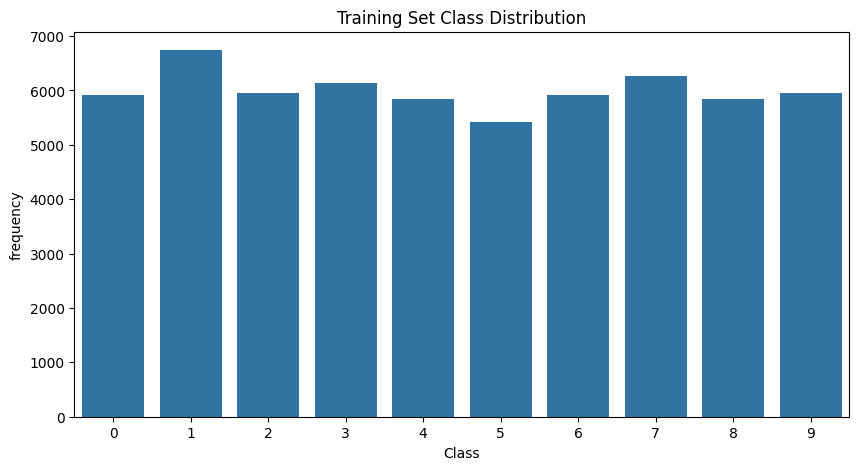

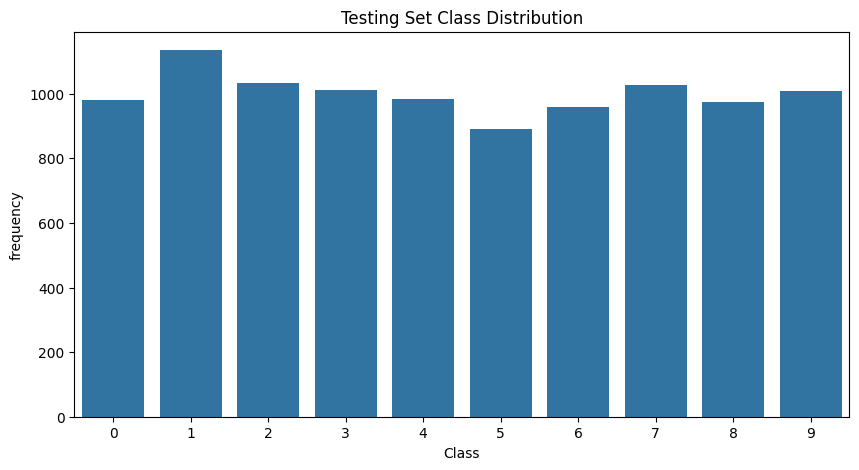

In [34]:
# Let's look at the class distribution. We want to identify whether the classes are balanced.
train_labels_df = pd.DataFrame(train_dataset.targets.numpy(), columns=['label'])
test_labels_df = pd.DataFrame(test_dataset.targets.numpy(), columns=['label'])

def plot_class_distribution(labels_df, title):
    plt.figure(figsize=(10, 5))
    sns.countplot(data=labels_df, x = 'label')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('frequency')
    plt.show()

plot_class_distribution(train_labels_df, 'Training Set Class Distribution')
plot_class_distribution(test_labels_df, 'Testing Set Class Distribution')


We see that the classes are slightly imbalanced. However, we can also observe that the imbalances are roughly similar in both datasets. This means that (at least for now) we do not have to account for the imbalances, as this imbalance also occurs in the test dataset - thus if the model does well on the imbalance in the training dataset, it hopefully also does on the testing dataset. Keep in mind that this is often not how it goes in real-life scenarios, i.e. the testing data is often not known/unavailable.

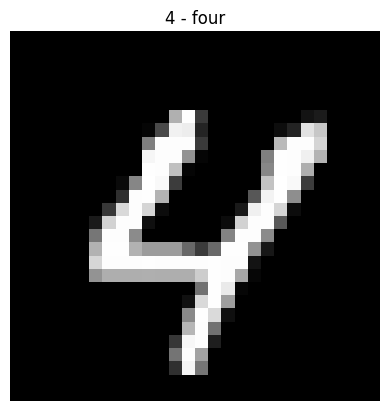

In [35]:
# We might want to set the seed to plot the same images
# torch.manual_seed(9)

class_names = train_dataset.classes

random_idx = torch.randint(low=0, high=len(train_dataset), size=[1]).item()
img, label = train_dataset[random_idx]
plt.imshow(img.squeeze(), cmap='gray') 
plt.title(class_names[label])
plt.axis('off')
plt.show()

From running the above code some times, we can see that most numbers look recognizable, but also that some are more difficult to guess than others. This is something we will have to take into account after our model has made predictions. It's always important to recognize that when our model makes mistakes, we *look* at these mistakes, because maybe we shouldn't call it a mistake:)

When we are working with images, we must not forget that each pixel is a feature. Therefore, as we would normally inspect our features (f.e. in tabular data) and their distribution, we can do the same for the pixels. For now, we will disregard the position of each pixel compared to one another, as we will flatten the images to a vector in order for our models to work. When using convolutional neural networks (CNNs), we will be using the spatial properties of the pixels.

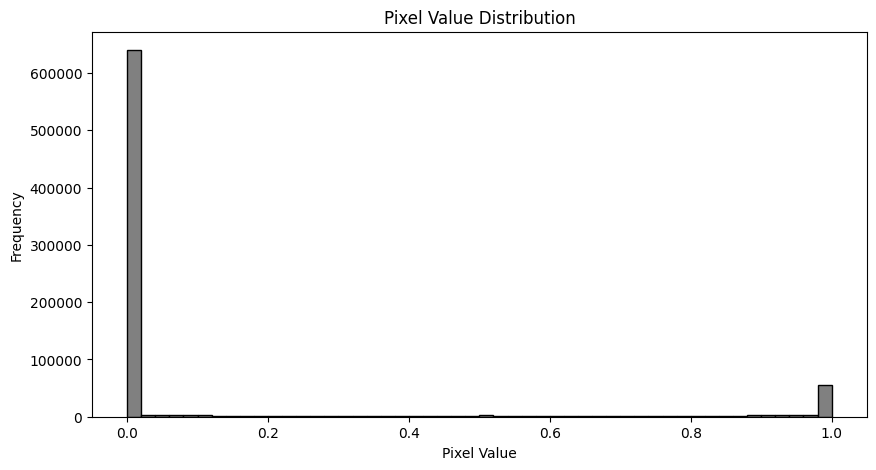

In [36]:
# Visualize the distribution of pixel values
def plot_pixel_distribution(dataset, num_samples=1000):
    pixels = np.concatenate([img.numpy().flatten() for img, _ in torch.utils.data.Subset(dataset, np.random.choice(len(dataset), num_samples, replace=False))])
    plt.figure(figsize=(10, 5))
    plt.hist(pixels, bins=50, color='gray', edgecolor='black')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Pixel Value Distribution')
    plt.show()

plot_pixel_distribution(train_dataset)

Now that we understand roughly what our data looks like, we will use DataLoaders to efficiently load the data into batches, which makes it easier to train neural networks. Moreover, we can decide whether we want to shuffle the data. We want to shuffle the data in the training dataloader to ensure diversity. There is also a lot of built-in support for data iteration, and just overall eases the job for us.

In [37]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Baseline linear model
We build a baseline linear model that we can use for comparison with later models (this will be especially important in the following two tutorials). However, in this tutorial, we will only use this model and rather focus on building a simple yet structured machine learning pipeline. 

In [38]:
class BaselineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(in_features=28*28, out_features=10)

    def forward(self, X):
        return self.linear(X.reshape(-1, 28*28))

This model is a simple linear model, which maps $28 \times 28$ pixels to our $10$ classes. It also has a bias parameter for each class. Therefore, we should have $28 \times 28 \times 10 + 10 = 7850$ parameters.

In [39]:
baseline_model = BaselineModel()
sum(p.numel() for p in baseline_model.parameters())

7850

All seems good, perfect.

Now we need to train the model, and after that we want to evaluate the model on unseen data. This is very important as it allows for a proper evaluation of model performance (see [1](https://d2l.ai/chapter_linear-regression/generalization.html#generalization) for a comprehensive introduction to generalization). 

At this stage, it is very important to make a proper pipeline - that is, create functions that are very general, and can be used by different models with different hyperparameters (or even different datasets - make it general enough for the project you're tackling). This might take a bit more time at the start of a project (although this will get easier and easier), but you will save a lot of time when experimenting with different designs. Also, it makes it easier for others to use your code.

In [47]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device=device):
    train_loss, train_acc = 0, 0
    model.to(device) # We set the model to our device for faster computation.
    model.train()
    
    for X, y in data_loader:
        X, y = X.to(device), y.to(device) # We set the data to our device for faster computation.
        y_pred = model(X) # We make the predictions

        loss = loss_fn(y_pred, y) 
        acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        train_loss += loss.item()
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    return train_loss, train_acc

In [48]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device=device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device) 

            y_pred = model(X) 

            loss = loss_fn(y_pred, y)
            acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            test_loss += loss.item()
            test_acc += acc

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    
    return test_loss, test_acc

We can combine the training and testing/validation step. The 'test_step' function can be used both for validation data (data used for hyperparameter tuning) and for test data (data used only **once** when you're completely done with the model and want to test it one last time).

In [49]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10):
    
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        data_loader=test_dataloader,
                                        loss_fn=loss_fn)
        
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

We have set up quite a nice yet simple machine learning pipeline. Let's train and evaluate our first model. 

Because we aren't hyperparameter tuning just yet, a validation dataset is not necessary. However, for a complete overview I will create one nonetheless, so that we are sure that we only evaluate on the test data **once** at the end of our training process. There are many reasons for being careful with how and when you use your data (see [2](https://www.sciencedirect.com/science/article/abs/pii/S0149763420305868?via%3Dihub) for a paper on the dangers of using machine learning in neuroscience).

In [50]:
indices = np.arange(len(train_dataset))
np.random.shuffle(indices) # To ensure diversity when separating datasets

split_size = int(0.8 * len(indices)) # We make a 80% training, 20% validation split
train_indices = indices[:split_size]
val_indices = indices[split_size:]

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

train_dataloader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=64, shuffle=False) 

During training, the model's parameters are updated after each batch. Smaller batch sizes help the model to generalize better because of the noise introduced by the variability between different batches (the smaller the batch_size, the more noisy). This noise can act as a form of regularization. 

During validation and testing, we don't update the model's parameters. Instead, we are just evaluating the model's performance. Therefore, there's no need to introduce additional noise. Moreover, this will speed up the evaluation time.

In [51]:
baseline_model = BaselineModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=baseline_model.parameters(), lr=0.01)

results = train(model=baseline_model,
                train_dataloader=train_dataloader, 
                test_dataloader=val_dataloader, 
                optimizer=optimizer, 
                loss_fn=loss_fn)

 10%|█         | 1/10 [00:05<00:50,  5.61s/it]

Epoch: 1 | train_loss: 1.1592 | train_acc: 76.3620 | test_loss: 0.7479 | test_acc: 84.0104


 20%|██        | 2/10 [00:11<00:44,  5.60s/it]

Epoch: 2 | train_loss: 0.6473 | train_acc: 85.4115 | test_loss: 0.5787 | test_acc: 85.9583


 30%|███       | 3/10 [00:16<00:38,  5.57s/it]

Epoch: 3 | train_loss: 0.5390 | train_acc: 86.8385 | test_loss: 0.5100 | test_acc: 87.1146


 40%|████      | 4/10 [00:22<00:33,  5.52s/it]

Epoch: 4 | train_loss: 0.4868 | train_acc: 87.6146 | test_loss: 0.4719 | test_acc: 87.9583


 50%|█████     | 5/10 [00:27<00:27,  5.48s/it]

Epoch: 5 | train_loss: 0.4550 | train_acc: 88.1172 | test_loss: 0.4463 | test_acc: 88.5521


 60%|██████    | 6/10 [00:32<00:21,  5.45s/it]

Epoch: 6 | train_loss: 0.4327 | train_acc: 88.5521 | test_loss: 0.4276 | test_acc: 88.9062


 70%|███████   | 7/10 [00:38<00:16,  5.42s/it]

Epoch: 7 | train_loss: 0.4162 | train_acc: 88.8281 | test_loss: 0.4142 | test_acc: 89.0625


 80%|████████  | 8/10 [00:43<00:10,  5.43s/it]

Epoch: 8 | train_loss: 0.4032 | train_acc: 89.1172 | test_loss: 0.4035 | test_acc: 89.1979


 90%|█████████ | 9/10 [00:49<00:05,  5.45s/it]

Epoch: 9 | train_loss: 0.3927 | train_acc: 89.4375 | test_loss: 0.3942 | test_acc: 89.2917


100%|██████████| 10/10 [00:54<00:00,  5.47s/it]

Epoch: 10 | train_loss: 0.3840 | train_acc: 89.5521 | test_loss: 0.3863 | test_acc: 89.4375


It's good practice to plot the loss curves! (Some other metric can also be plotted to inspect performance)

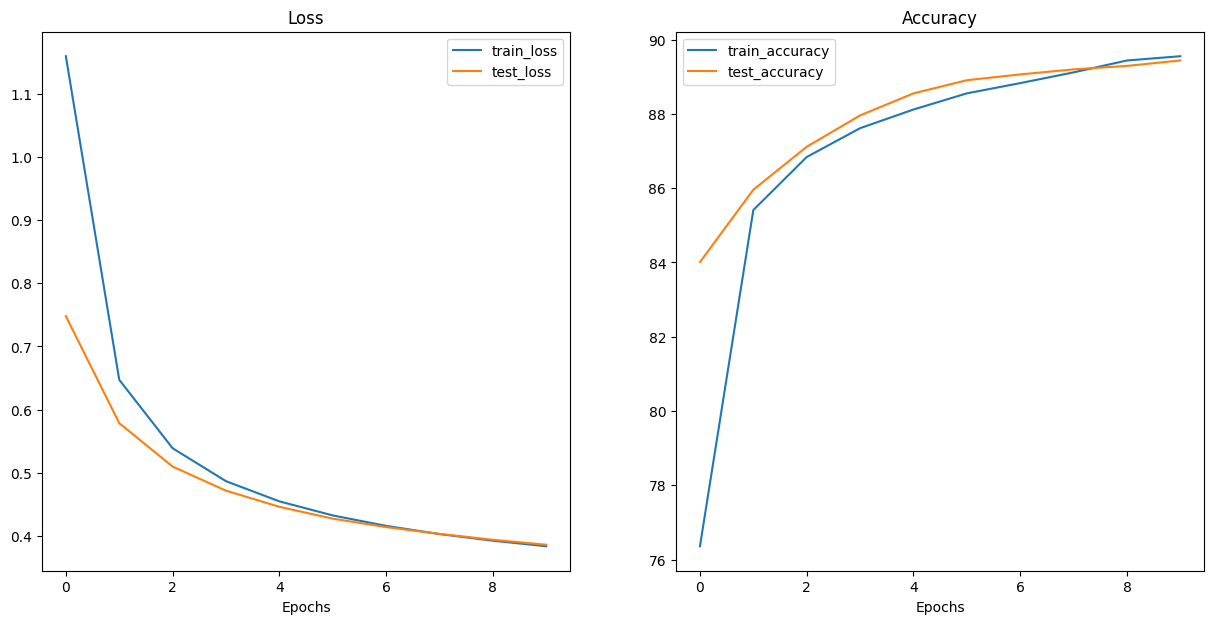

In [52]:
plot_loss_curves(results)

Now that we've trained our model, we can test it against the preserved test dataset for. This should be our final check to see if our model is robust (if we see it performs a lot worse on the test dataset, and we tune our model, then test again on the test dataset, it's not truly a test dataset anymore. Be careful with that!)

In [53]:
test_step(model=baseline_model,
          data_loader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

(0.3617585671792744, 90.38614649681529)

## Conclusion

I hope that this tutorial gives a brief overview of how to approach a machine learning problem in Pytorch. The main priority was to create a smooth training pipeline. As you can see it is now quite simple to create other models and compare them with others. In the following (intermediate) tutorial, the focus will be on extending the pipeline to involve proper cross-validation (for a robust performance measure), hyperparameter tuning, and experimenting with more complex models.

### Informal reference list

[1] https://d2l.ai/chapter_linear-regression/generalization.html#generalization 

[2] https://www.sciencedirect.com/science/article/abs/pii/S0149763420305868?via%3Dihub

Now, let's look at model that is slightly more complex than the linear model we made. We will introduce the power of non-linearity. This allows the model to find patterns in the data that are non-linear, which is not something that our baseline model can do. 

In [ ]:
class FFN(nn.Module):
    def __init__(self, hidden_units):
        super().__init__()
        self.layer1 = nn.Linear(28*28, hidden_units)
        self.layer2 = nn.Linear(hidden_units, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.reshape((-1, 28*28))
        return self.layer2(self.relu(self.layer1(x)))

In [ ]:
ffn = FFN(hidden_units=128)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=ffn.parameters(), lr=0.01)

results_ffn = train(model=ffn,
                    train_dataloader=train_loader,
                    test_dataloader=test_loader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=EPOCHS)


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 1.23919 | Train accuracy: 74.85%


 10%|█         | 1/10 [00:19<02:55, 19.49s/it]

Test loss: 0.58579 | Test accuracy: 86.68%
Epoch: 1 | train_loss: 1.2392 | train_acc: 74.8484 | test_loss: 0.5858 | test_acc: 86.6839
Train loss: 0.49438 | Train accuracy: 87.52%


 20%|██        | 2/10 [00:38<02:32, 19.05s/it]

Test loss: 0.40459 | Test accuracy: 89.38%
Epoch: 2 | train_loss: 0.4944 | train_acc: 87.5250 | test_loss: 0.4046 | test_acc: 89.3810
Train loss: 0.39378 | Train accuracy: 89.26%


 30%|███       | 3/10 [00:56<02:09, 18.49s/it]

Test loss: 0.34949 | Test accuracy: 90.39%
Epoch: 3 | train_loss: 0.3938 | train_acc: 89.2557 | test_loss: 0.3495 | test_acc: 90.3861
Train loss: 0.35361 | Train accuracy: 90.10%


 40%|████      | 4/10 [01:14<01:50, 18.47s/it]

Test loss: 0.32220 | Test accuracy: 90.82%
Epoch: 4 | train_loss: 0.3536 | train_acc: 90.1019 | test_loss: 0.3222 | test_acc: 90.8240
Train loss: 0.32925 | Train accuracy: 90.64%


 50%|█████     | 5/10 [01:32<01:31, 18.36s/it]

Test loss: 0.30484 | Test accuracy: 91.40%
Epoch: 5 | train_loss: 0.3293 | train_acc: 90.6433 | test_loss: 0.3048 | test_acc: 91.4013
Train loss: 0.31208 | Train accuracy: 91.17%


 60%|██████    | 6/10 [01:50<01:13, 18.30s/it]

Test loss: 0.29082 | Test accuracy: 91.85%
Epoch: 6 | train_loss: 0.3121 | train_acc: 91.1714 | test_loss: 0.2908 | test_acc: 91.8491
Train loss: 0.29749 | Train accuracy: 91.55%


 70%|███████   | 7/10 [02:10<00:56, 18.78s/it]

Test loss: 0.27862 | Test accuracy: 92.15%
Epoch: 7 | train_loss: 0.2975 | train_acc: 91.5462 | test_loss: 0.2786 | test_acc: 92.1477
Train loss: 0.28534 | Train accuracy: 91.91%


 80%|████████  | 8/10 [02:28<00:36, 18.36s/it]

Test loss: 0.27090 | Test accuracy: 92.36%
Epoch: 8 | train_loss: 0.2853 | train_acc: 91.9143 | test_loss: 0.2709 | test_acc: 92.3567
Train loss: 0.27415 | Train accuracy: 92.22%


 90%|█████████ | 9/10 [02:46<00:18, 18.39s/it]

Test loss: 0.26089 | Test accuracy: 92.71%
Epoch: 9 | train_loss: 0.2741 | train_acc: 92.2208 | test_loss: 0.2609 | test_acc: 92.7150
Train loss: 0.26380 | Train accuracy: 92.50%


100%|██████████| 10/10 [03:05<00:00, 18.52s/it]

Test loss: 0.25175 | Test accuracy: 92.83%
Epoch: 10 | train_loss: 0.2638 | train_acc: 92.4957 | test_loss: 0.2517 | test_acc: 92.8344


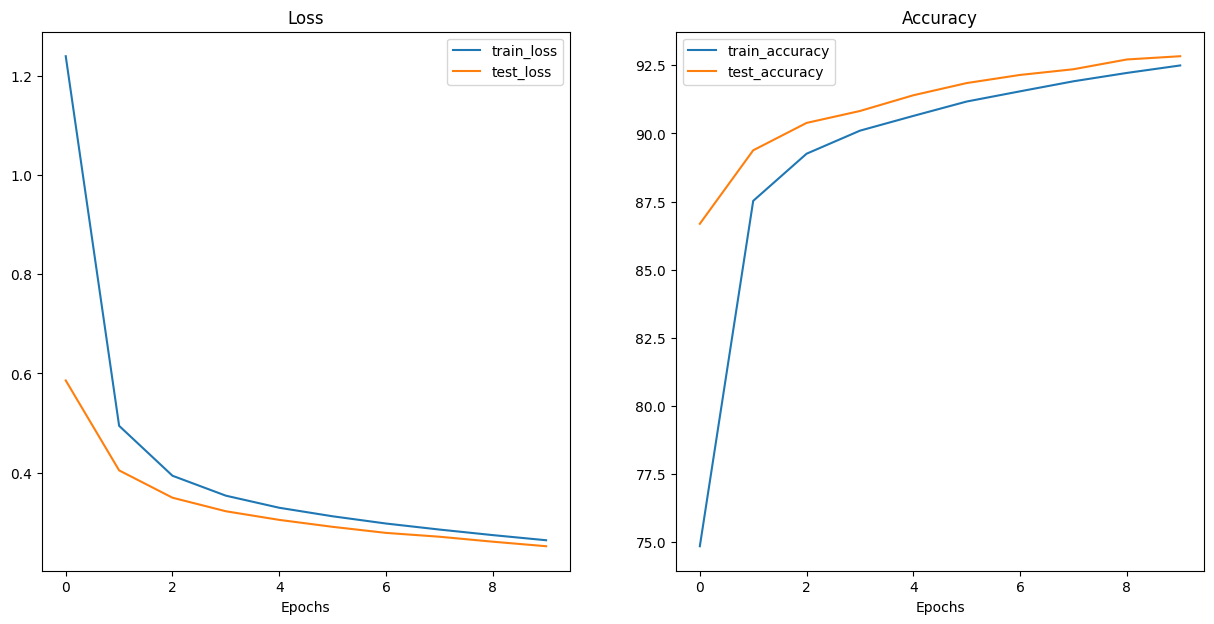

In [ ]:
plot_loss_curves(results_ffn)

We can see that by simply introducing one hidden layer and a non-linear activation function (in this case ReLU), our model does quite a lot better already. 